In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
couponitemmapping = pd.read_csv('coupon_item_mapping.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [3]:
couponitemmapping.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [4]:
item_data = pd.read_csv('item_data.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [5]:
item_data.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [6]:
items = item_data

In [7]:
items.loc[items['brand_type'].str.match('Local')==True,'brand_type'] = 0

In [8]:
items.loc[items['brand_type'].str.match('Established')==True,'brand_type'] = 1

In [9]:
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
items['category'] = number.fit_transform(items['category'].astype('str'))

In [10]:
items.head()

,item_id,brand,brand_type,category
0,1,1,1,6
1,2,1,1,8
2,3,56,0,1
3,4,56,0,6
4,5,56,0,6


In [11]:
step1 = pd.merge(couponitemmapping, items, how='left', on='item_id')

In [12]:
step1.isna().sum()

coupon_id     0
item_id       0
brand         0
brand_type    0
category      0
dtype: int64

In [13]:
customer_transaction_data = pd.read_csv('customer_transaction_data.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [14]:
transactions = customer_transaction_data

In [15]:
transactions['redemption'] = 1
transactions.loc[transactions['coupon_discount']==0,'redemption'] = '0'
transactions.loc[transactions['other_discount']==0,'redemption'] = '0'

In [16]:
transactions['selling_price'] = transactions['selling_price']/transactions['quantity']
transactions['other_discount'] = transactions['other_discount']/transactions['quantity']
transactions['selling_price'] = transactions['selling_price'] - transactions['other_discount']

In [17]:
transactions = transactions.astype({"redemption": int})

In [18]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions = transactions.sort_values('date').reset_index(drop=True)

In [19]:
transactions['jour'] = transactions["date"].apply(lambda x: x.day)
transactions['week'] = transactions["date"].apply(lambda x: x.weekday())
transactions['mois'] = transactions["date"].apply(lambda x: x.month)

In [20]:
transactionsx1 = pd.pivot_table(transactions, index = "item_id",
                              values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount','redemption'],
                              aggfunc={'customer_id':lambda x: len(set(x)),
                                       'quantity':np.sum,
                                       'selling_price':np.sum,
                                       'other_discount':np.sum,
                                       'coupon_discount':np.sum,
                                       'redemption': np.sum})

In [21]:
transactionsx1.reset_index(inplace=True)
transactionsx1.rename(columns={'customer_id': 'nb_customers', 'quantity':'qua_sum','selling_price':'prix_sum', 'other_discount':'oth_sum','coupon_discount':'coup_sum'}, inplace=True)

In [22]:
transactionsx2 = pd.pivot_table(transactions, index = "item_id", values=['customer_id'], aggfunc={'customer_id':len} )

In [23]:
transactionsx2.reset_index(inplace=True)
transactionsx2.rename(columns={'customer_id': 'tot_customers'}, inplace=True)

In [24]:
transactionsx3 = pd.merge(transactionsx1, transactionsx2, on='item_id', how='left')

In [25]:
transactionsx3['total_dsc_sum'] = transactionsx3['oth_sum'] + transactionsx3['coup_sum']
transactionsx3.head()

,item_id,coup_sum,nb_customers,oth_sum,qua_sum,redemption,prix_sum,tot_customers,total_dsc_sum
0,1,0.0,2,0.0,2,0,248.62,2,0.0
1,2,0.0,1,0.0,1,0,35.26,1,0.0
2,3,0.0,1,0.0,1,0,56.64,1,0.0
3,4,0.0,1,0.0,1,0,54.85,1,0.0
4,5,0.0,1,0.0,1,0,81.57,1,0.0


In [26]:
transactionsx3.isna().sum()

item_id          0
coup_sum         0
nb_customers     0
oth_sum          0
qua_sum          0
redemption       0
prix_sum         0
tot_customers    0
total_dsc_sum    0
dtype: int64

In [27]:
step2 = pd.merge(step1, transactionsx3, how='left', on='item_id')

In [28]:
coupon_table = pd.pivot_table(step2, index =['coupon_id','brand','brand_type','category','nb_customers'],
                        values=[ 'item_id', 'redemption','coup_sum','tot_customers', 'oth_sum', 'qua_sum',
                                'prix_sum','total_dsc_sum'],
                        aggfunc={'item_id':lambda x: len(set(x)),
                                 'redemption': np.sum,    
                                 'coup_sum': np.sum,
                                 'tot_customers': np.sum,
                                 'oth_sum': np.sum,
                                 'qua_sum': np.sum,
                                 'prix_sum': np.sum,
                                 'total_dsc_sum': np.sum})

In [29]:
coupon_table.reset_index(inplace=True)

In [30]:
coupon_table.rename(columns={'item_id':'nb_item_counts'}, inplace=True)

In [31]:
transactionsy3= pd.pivot_table(transactions, index = ['customer_id'],
                                values=['item_id','quantity','selling_price', 'other_discount','coupon_discount','redemption'],
                                aggfunc={'item_id':lambda x: len(set(x)),
                                         'quantity':np.sum,
                                         'selling_price':np.sum,
                                         'other_discount':np.sum,
                                         'coupon_discount':np.sum,
                                         'redemption': np.sum})

In [32]:
transactionsy3.reset_index(inplace=True)
transactionsy3.rename(columns={'item_id': 'nbo_items','quantity':'qoa_sum','selling_price':'prec_sum',
                             'other_discount':'othe_sum','coupon_discount':'code_sum'}, inplace=True)
transactionsy3.head()

,customer_id,code_sum,nbo_items,othe_sum,qoa_sum,redemption,prec_sum
0,1,-2116.83,463,-13453.738833,1227,45,102149.063000
1,2,-249.34,352,-5628.089833,474,2,45170.623167
2,3,-2179.54,406,-9922.771654,8163,28,59983.128347
3,4,-89.05,125,-1954.404333,280,1,30416.489333
4,5,-90.83,490,-8918.471477,93353,2,91462.410620


In [33]:
transactionsy4 = pd.pivot_table(transactions, index = "customer_id", values=['item_id'], aggfunc={'item_id':len})

In [34]:
transactionsy4.reset_index(inplace=True)
transactionsy4.rename(columns={'item_id': 'cust_id_count'}, inplace=True)
transactionsy4.head()

,customer_id,cust_id_count
0,1,1048
1,2,419
2,3,705
3,4,220
4,5,792


In [35]:
transactionsz = pd.merge(transactionsy3, transactionsy4, how='left',on='customer_id')
transactionsz.head()

,customer_id,code_sum,nbo_items,othe_sum,qoa_sum,redemption,prec_sum,cust_id_count
0,1,-2116.83,463,-13453.738833,1227,45,102149.063000,1048
1,2,-249.34,352,-5628.089833,474,2,45170.623167,419
2,3,-2179.54,406,-9922.771654,8163,28,59983.128347,705
3,4,-89.05,125,-1954.404333,280,1,30416.489333,220
4,5,-90.83,490,-8918.471477,93353,2,91462.410620,792


In [36]:
transactionsz.isna().sum()

customer_id      0
code_sum         0
nbo_items        0
othe_sum         0
qoa_sum          0
redemption       0
prec_sum         0
cust_id_count    0
dtype: int64

In [37]:
campaign_data = pd.read_csv('campaign_data.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [38]:
campaign_data.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [39]:
campaign = campaign_data

In [40]:
campaign.loc[campaign['campaign_type'].str.match('Y')==True,'campaign_type'] = 0

In [41]:
campaign.loc[campaign['campaign_type'].str.match('X')==True,'campaign_type'] = 1

In [42]:
campaign['duration'] = pd.to_datetime(campaign['end_date']) - pd.to_datetime(campaign['start_date'])

In [43]:
campaign['duration'] = campaign['duration'].dt.days

In [44]:
campaign['start_date'] = pd.to_datetime(campaign['start_date'], format = '%d/%m/%y')
campaign['end_date'] = pd.to_datetime(campaign['end_date'], format = '%d/%m/%y')

In [45]:
campaign = campaign.astype({"campaign_type": int})

In [46]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date,duration
0,24,0,2013-10-21,2013-12-20,60
1,25,0,2013-10-21,2013-11-22,32
2,20,0,2013-09-07,2013-11-16,130
3,23,0,2013-10-08,2013-11-15,97
4,21,0,2013-09-16,2013-10-18,32


In [47]:
customer_demographics = pd.read_csv('customer_demographics.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [48]:
customer_demographics.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [49]:
customerv2 = customer_demographics

In [50]:
customerv2.loc[customerv2['marital_status'].isna()==True,'marital_status'] = 'Single'

In [51]:
customerv2.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,Single,0,3,1,3
3,8,26-35,Single,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [52]:
customerv2.loc[customerv2['no_of_children'].isna()==True]

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
4,10,46-55,Single,0,1,NaN,5
5,11,70+,Single,0,2,NaN,1
6,12,46-55,Married,0,2,NaN,7
...,...,...,...,...,...,...,...
753,1573,46-55,Single,0,1,NaN,4
754,1574,36-45,Married,0,2,NaN,5
755,1577,36-45,Single,0,2,NaN,5
757,1579,46-55,Single,0,1,NaN,4


In [53]:
customerv2.loc[customerv2['no_of_children'].isna()==True,'no_of_children'] = '2'

In [54]:
customerv2.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,2,4
1,6,46-55,Married,0,2,2,5
2,7,26-35,Single,0,3,1,3
3,8,26-35,Single,0,4,2,6
4,10,46-55,Single,0,1,2,5


In [55]:
dummies_v1 = pd.get_dummies(customerv2.age_range).add_prefix('cust_age_')

In [56]:
dummies_v2 = pd.get_dummies(customerv2.marital_status).add_prefix('cust_marit_')

In [57]:
dummies_v3 = pd.get_dummies(customerv2.no_of_children).add_prefix('cust_child_')

In [58]:
dummies_v4 = pd.get_dummies(customerv2.income_bracket).add_prefix('cust_inco_')

In [59]:
dummies_v5 = pd.get_dummies(customerv2.family_size).add_prefix('cust_fam_')

In [60]:
dummies_v3.head()

,cust_child_1,cust_child_2,cust_child_3+
0,0,1,0
1,0,1,0
2,1,0,0
3,0,1,0
4,0,1,0


In [61]:
cust_merged = pd.concat([customerv2, dummies_v1,dummies_v2,dummies_v3,dummies_v4,dummies_v5], axis='columns')

In [62]:
demographics = cust_merged.drop(['age_range', 'income_bracket','family_size','no_of_children','marital_status'], axis='columns')

In [63]:
train_data = pd.read_csv('train.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [64]:
train_data.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [65]:
train= train_data

In [66]:
test_data = pd.read_csv('test.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [67]:
test = test_data

In [70]:
#train = train.drop(['id','customer_id'], axis='columns')

In [68]:
train.isna().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64

In [65]:
#traincamp = pd.merge(train, campaign, how='inner', on='campaign_id')

In [66]:
#traincamp.drop_duplicates(subset=['campaign_id'], keep='first', inplace=True, ignore_index=True)

In [83]:
#basex25.astype({"brand_type": int})

In [129]:
#basex25.astype({"campaign_type": int})

In [100]:
#ww["rented"].fillna(ww.rented.mode(dropna=True), inplace=True)

In [107]:
xx = pd.merge(train, coupon_table, on="coupon_id", how="left")
yy = pd.merge(xx, campaign, on="campaign_id", how="left")
zz = pd.merge(yy, demographics, on="customer_id", how="left")
ww = pd.merge(zz, transactionsz, on='customer_id', how='left')

In [108]:
ww.drop(['id',
         'campaign_id',
         'coupon_id',
         'customer_id',
         'start_date',
         'end_date',
         'cust_fam_5+',
         'cust_inco_10',
         'cust_inco_12',
         'cust_child_3+',
         'cust_inco_2',
         'cust_inco_11',
         'cust_age_36-45',
         'redemption_x',
         'qua_sum',
         'tot_customers',
         'cust_id_count',
         'prec_sum',
         'nbo_items',
         'othe_sum',
         'oth_sum',
         'cust_child_2',
         'total_dsc_sum',
         'cust_fam_4',
         'cust_marit_Single',
         'coup_sum'], axis=1, inplace=True)

In [109]:
for column in ww:
    mode = ww[column].mode(dropna=True)
    ww[column] = ww[column].fillna(0)

In [110]:
ww.isna().sum()

redemption_status     0
brand                 0
brand_type            0
category              0
nb_customers          0
nb_item_counts        0
prix_sum              0
campaign_type         0
duration              0
rented                0
cust_age_18-25        0
cust_age_26-35        0
cust_age_46-55        0
cust_age_56-70        0
cust_age_70+          0
cust_marit_Married    0
cust_child_1          0
cust_inco_1           0
cust_inco_3           0
cust_inco_4           0
cust_inco_5           0
cust_inco_6           0
cust_inco_7           0
cust_inco_8           0
cust_inco_9           0
cust_fam_1            0
cust_fam_2            0
cust_fam_3            0
code_sum              0
qoa_sum               0
redemption_y          0
dtype: int64

In [111]:
ww['qoa_sum'] = ww['qoa_sum'].apply(loggi)
ww['redemption_y'] = ww['redemption_y'].apply(loggi)
ww['code_sum'] = ww['code_sum'].apply(loggi)
ww['duration'] = ww['duration'].apply(loggi)
ww['prix_sum'] = ww['prix_sum'].apply(loggi)
ww['category'] = ww['category'].apply(loggi)
ww['nb_customers'] = ww['nb_customers'].apply(loggi)
ww['nb_item_counts'] = ww['nb_item_counts'].apply(loggi)

In [113]:
ww['brand'] = ww['brand'].apply(loggi)

In [131]:
#train = merge_todo(train)
#test = merge_todo(test)

In [114]:
ww.head()

,redemption_status,brand,brand_type,category,nb_customers,nb_item_counts,prix_sum,campaign_type,duration,rented,...,cust_inco_6,cust_inco_7,cust_inco_8,cust_inco_9,cust_fam_1,cust_fam_2,cust_fam_3,code_sum,qoa_sum,redemption_y
0,0,7.007601,1,1.791759,0.000000,3.332205,7.937662,1,-2.484907,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.489198,11.56695,0.0
1,0,7.007601,1,1.791759,0.693147,1.098612,6.681532,1,-2.484907,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.489198,11.56695,0.0
2,0,7.007601,1,1.791759,1.098612,0.000000,5.629598,1,-2.484907,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.489198,11.56695,0.0
3,0,7.007601,1,1.791759,2.564949,0.000000,8.123604,1,-2.484907,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.489198,11.56695,0.0
4,0,7.007601,1,1.791759,2.708050,0.000000,7.868400,1,-2.484907,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.489198,11.56695,0.0


In [71]:
#ww.drop(['id','campaign_id','coupon_id','customer_id','start_date','end_date'], axis=1, inplace=True)

In [ ]:
#Variables that the VIF show a high correlation
'qua_sum'
'tot_customers'
'cust_id_count'
'prec_sum'
'nbo_items'
'othe_sum'

In [115]:
ww = ww.dropna()

In [116]:
ww.head()

,redemption_status,brand,brand_type,category,nb_customers,nb_item_counts,prix_sum,campaign_type,duration,rented,...,cust_inco_6,cust_inco_7,cust_inco_8,cust_inco_9,cust_fam_1,cust_fam_2,cust_fam_3,code_sum,qoa_sum,redemption_y
0,0,7.007601,1,1.791759,0.000000,3.332205,7.937662,1,-2.484907,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.489198,11.56695,0.0
1,0,7.007601,1,1.791759,0.693147,1.098612,6.681532,1,-2.484907,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.489198,11.56695,0.0
2,0,7.007601,1,1.791759,1.098612,0.000000,5.629598,1,-2.484907,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.489198,11.56695,0.0
3,0,7.007601,1,1.791759,2.564949,0.000000,8.123604,1,-2.484907,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.489198,11.56695,0.0
4,0,7.007601,1,1.791759,2.708050,0.000000,7.868400,1,-2.484907,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.489198,11.56695,0.0


In [117]:
wow = ww

In [118]:
y = wow['redemption_status']
X = wow.drop('redemption_status', axis = 1)

In [85]:
y = y.astype(int)

In [86]:
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [89]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state =15, criterion = 'entropy', max_depth = 10) 
dt.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

In [ ]:
sort = df.feature_importances_.argsort()
plt.barh(boston.feature_names[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [90]:
importances = dt.feature_importances_
# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = ww.columns[1:]
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[sorted_indices[f]], importances[sorted_indices[f]]))

 1) redemption_y                   0.381356
 2) category                       0.080165
 3) code_sum                       0.067054
 4) duration                       0.063447
 5) nbo_items                      0.062902
 6) qoa_sum                        0.062051
 7) cust_inco_5                    0.045298
 8) prec_sum                       0.039555
 9) cust_id_count                  0.037242
10) campaign_type                  0.032937
11) othe_sum                       0.024709
12) cust_marit_Married             0.017016
13) cust_fam_3                     0.013172
14) cust_child_2                   0.012651
15) brand                          0.012031
16) cust_inco_1                    0.011856
17) cust_inco_9                    0.010406
18) cust_age_56-70                 0.008232
19) cust_inco_7                    0.005849
20) cust_inco_4                    0.003741
21) cust_fam_1                     0.002940
22) cust_age_46-55                 0.001601
23) total_dsc_sum               

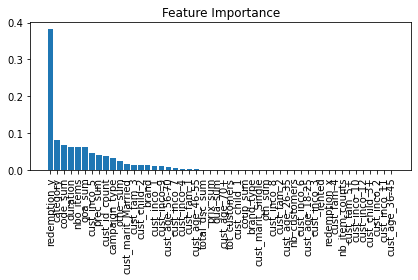

In [91]:
import matplotlib.pyplot as plt
 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()



Text(0.5, 0, 'Feature Importance')

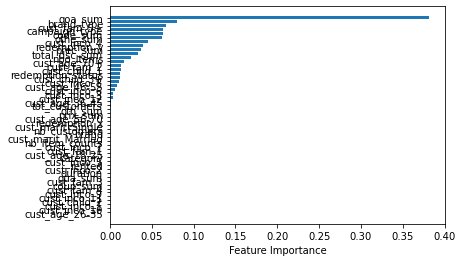

In [94]:
sort = importances.argsort()
plt.barh(ww.columns[sort], dt.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [76]:
wow = ww.astype(float)

In [103]:
wiw = wow

In [291]:
wiw.drop(['redemption_status',
'brand_type',
'campaign_type',
'cust_age_18-25',
'cust_age_26-35',
'cust_age_36-45',
'cust_age_46-55',
'cust_age_56-70',
'cust_age_70+',
'cust_marit_Married',
'cust_marit_Single',
'cust_child_1',
'cust_child_2',
'cust_child_3+',
'cust_inco_1',
'cust_inco_2',
'cust_inco_3',
'cust_inco_4',
'cust_inco_5',
'cust_inco_6',
'cust_inco_7',
'cust_inco_8',
'cust_inco_9',
'cust_inco_10',
'cust_inco_11',
'cust_inco_12',
'cust_fam_1',
'cust_fam_2',
'cust_fam_3',
'cust_fam_4',
'cust_fam_5+'], axis=1, inplace=True)

In [322]:
y = wow['redemption_status']
X = wow.drop('redemption_status', axis = 1)

In [295]:
wiw = wiw.astype(float)

In [325]:
len(y)

43661

In [326]:
#test_id = test1['id']
#test1.drop(['id','campaign_id','start_date','end_date'], axis=1, inplace=True)

In [275]:
X

,coupon_id,customer_id,brand,brand_type,category,coup_sum,coupon_discount_x,item_counts,nb_customers,oth_sum,...,other_discount_y,quantity_y,redemption_y,selling_price_y,week,code_sum,cust_id_count,othe_sum,qoa_sum,prec_sum
0,27.0,1053.0,1105.0,1.0,6.0,-5349.93,-1.241694,125.0,19.224000,-177447.090167,...,-25.583099,340.487097,1.0,163.966826,2.0,-89.05,310.0,-7930.760842,105551.0,50829.715972
1,116.0,48.0,56.0,0.0,6.0,0.00,0.000000,3.0,20.333333,-586.140000,...,-20.013685,31.540260,4.0,188.638474,5.0,-1237.79,385.0,-7705.268702,12143.0,72625.812434
2,635.0,205.0,560.0,1.0,11.0,-605.54,-2.987321,67.0,1.761194,-12475.083333,...,-12.873370,1.392784,51.0,112.067666,2.0,-2145.72,970.0,-12487.169143,1351.0,108705.636349
4,1017.0,1489.0,1558.0,1.0,6.0,-569.92,-0.198055,32.0,27.312500,-46796.046667,...,-12.264174,247.443060,3.0,85.016352,4.0,-265.01,562.0,-6892.466021,139063.0,47779.189609
5,795.0,793.0,948.0,1.0,11.0,0.00,0.000000,13.0,2.769231,-951.060000,...,-12.796770,93.200000,5.0,117.668640,5.0,-989.87,1720.0,-22010.443947,160304.0,202390.060583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78360,475.0,207.0,190.0,1.0,12.0,-138.92,-1.084743,17.0,5.470588,-617.235000,...,-10.195422,312.800131,11.0,114.951980,4.0,-776.50,1521.0,-15507.236708,475769.0,174841.960840
78363,291.0,58.0,4368.0,1.0,11.0,0.00,0.000000,4.0,6.750000,-498.680000,...,-14.935134,121.237179,2.0,94.136490,3.0,-108.64,1092.0,-16309.166005,132391.0,102797.047552
78364,71.0,1523.0,56.0,0.0,6.0,0.00,0.000000,4.0,40.750000,-5035.362056,...,-8.282240,1.064935,0.0,119.448066,3.0,0.00,462.0,-3826.395000,492.0,55185.006667
78365,547.0,937.0,2188.0,1.0,6.0,-35.62,-0.010943,7.0,35.571429,-20891.575000,...,-13.204228,1.206226,1.0,91.641946,6.0,-89.05,257.0,-3393.486667,310.0,23551.980000


In [78]:
!pip3 install imblearn

In [79]:
import sklearn.metrics

In [80]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [81]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [292]:
from sklearn.datasets import load_diabetes

In [ ]:
'qua_sum'
'tot_customers'
'cust_id_count'
'prec_sum'
'nbo_items'
'othe_sum'

In [293]:
import sklearn
from sklearn.model_selection import train_test_split #sklearn import does not automatically install sub packages
from sklearn import linear_model
import statsmodels.api as sm

In [104]:
#calculate Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = wiw.columns 
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(wiw.values, i) for i in range(len(wiw.columns))] 
    'cust_marit_Married'
    'coup_sum'
display(vif_scores)

C:\Users\daniel.galdo\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Attribute,VIF Scores
0,redemption_status,1.300392
1,brand,2.802216
2,brand_type,8.790576
3,category,7.386940
4,nb_customers,5.024772
5,coup_sum,inf
6,nb_item_counts,1.168340
7,oth_sum,inf
8,prix_sum,9.465822
9,qua_sum,22.146653


In [105]:
vif_scores.loc[vif_scores['VIF Scores']>11]

'qua_sum'*****
'tot_customers'****
'cust_id_count'*****
'prec_sum'****
'nbo_items'****
'othe_sum'***
'oth_sum'
'cust_marit_Single'
'cust_child_2'
'total_dsc_sum'
'cust_fam_4'

,Attribute,VIF Scores
5,coup_sum,inf
7,oth_sum,inf
9,qua_sum,22.146653
10,tot_customers,34.538737
11,total_dsc_sum,inf
20,cust_marit_Married,11.180288
21,cust_marit_Single,17.106407
22,cust_child_1,34.954105
23,cust_child_2,168.218057
32,cust_fam_1,80.600374


In [142]:
X.drop(['coup_sum',
'coupon_discount_x',
'item_counts',
'oth_sum',
'other_discount_x',
'prix_sum',
'qua_sum',
'redemption_x',
'tot_counts',
'total_dsc_mean',
'total_dsc_sum',
'redemption_y',
'code_sum',
'cust_id_count',
'othe_sum',
'prec_sum'], axis=1, inplace=True)

In [307]:
#After VIF validation
X.drop(['category',
'coup_sum',
'coupon_discount_x',
'item_counts',
'oth_sum',
'other_discount_x',
'prix_sum',
'qua_sum',
'quantity_x',
'redemption_x',
'tot_counts',
'total_dsc_mean',
'total_dsc_sum',
'nbo_items',
'other_discount_y',
'redemption_y',
'selling_price_y',
'code_sum',
'cust_id_count',
'othe_sum',
'prec_sum'], axis=1, inplace=True)

In [100]:
len(X)

2600218

In [96]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
ww['qoa_sum'] = ww['qoa_sum'].apply(loggi)
ww['redemption_y'] = ww['redemption_y'].apply(loggi)
ww['code_sum'] = ww['code_sum'].apply(loggi)
ww['duration'] = ww['duration'].apply(loggi)
ww['prix_sum'] = ww['prix_sum'].apply(loggi)
ww['category'] = ww['category'].apply(loggi)
ww['nb_customers'] = ww['prix_sum'].apply(loggi)
ww['nb_item_counts'] = ww['nb_item_counts'].apply(loggi)


In [105]:
import math
def loggi(x):
    m = abs(x)
    return ( (x//m) * math.log(m) if (x) else x)

In [112]:
#basex.to_csv(r'C:\Users\daniel.galdo\Documents\Thesis\basex.csv')

In [ ]:
#basex = pd.read_csv('basex.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [119]:
#spliting our data into training and testing features and targets
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size =0.3, random_state = 0)

In [120]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.129894
         Iterations 9
                           Results: Logit
Model:               Logit             Pseudo R-squared: 0.324      
Dependent Variable:  redemption_status AIC:              472911.8318
Date:                2023-01-03 22:43  BIC:              473284.2647
No. Observations:    1820152           Log-Likelihood:   -2.3643e+05
Df Model:            29                LL-Null:          -3.4950e+05
Df Residuals:        1820122           LLR p-value:      0.0000     
Converged:           1.0000            Scale:            1.0000     
No. Iterations:      9.0000                                         
--------------------------------------------------------------------
                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
brand              -0.1332   0.0032  -40.9816 0.0000 -0.1395 -0.1268
brand_type          0.1385  

In [278]:
X.drop(['coupon_id',
'customer_id',
'brand',
'brand_type',
'category',
'item_counts',
'nb_customers',
'prix_sum',
'qua_sum',
'quantity_x',
'redemption_x',
'selling_price_x',
'tot_counts',
'campaign_type',
'duration',
'coupon_discount_y',
'nbo_items',
'mois',
'other_discount_y',
'quantity_y',
'redemption_y',
'selling_price_y',
'code_sum',
'cust_id_count',
'othe_sum',
'prec_sum'], axis=1, inplace=True)

In [162]:
len(X)/len(y)

1.0

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\daniel.galdo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [122]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [124]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[739572   3281]
 [ 31369   5844]]


In [97]:
from imblearn.over_sampling import SMOTE 

In [83]:
import sklearn
from sklearn.model_selection import train_test_split #sklearn import does not automatically install sub packages
from sklearn import linear_model
import statsmodels.api as sm

In [ ]:
new_ads_merged[new_ads_merged.classifiedId.duplicated()]

In [126]:
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
(sum(y_pred)/len(y_pred))*100

C:\Users\daniel.galdo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.1697728140952177

In [ ]:
pip install scikit-learn